In [1]:
!pip install geopandas

In [2]:
!pip install geodatasets

In [3]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 39.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import geopandas as gpd
import geodatasets
import matplotlib.patches as mpatches
import pycountry
import re
from google.colab import files

In [5]:
# Loading the data and getting basic metrics
df = pd.read_csv('TIFF_Festival_1.csv')
df.info()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Title                954 non-null    object 
 1   Venue                954 non-null    object 
 2   Room                 954 non-null    object 
 3   Date                 954 non-null    object 
 4   Start Time           954 non-null    object 
 5   End Date             954 non-null    object 
 6   End Time             954 non-null    object 
 7   Priority/Premium     954 non-null    object 
 8   Audience Type        954 non-null    object 
 9   Extended Q&A         954 non-null    object 
 10  Countries            922 non-null    object 
 11  Languages            912 non-null    object 
 12  Programme or Series  954 non-null    object 
 13  Directors            922 non-null    object 
 14  Region Availability  0 non-null      float64
dtypes: float64(1), object(14)
memory usage: 

In [6]:
# Display the columns to understand the structure
df.columns

Index(['Title', 'Venue', 'Room', 'Date', 'Start Time', 'End Date', 'End Time',
       'Priority/Premium', 'Audience Type', 'Extended Q&A', 'Countries',
       'Languages', 'Programme or Series', 'Directors', 'Region Availability'],
      dtype='object')

In [7]:
df.head()

,Title,Venue,Room,Date,Start Time,End Date,End Time,Priority/Premium,Audience Type,Extended Q&A,Countries,Languages,Programme or Series,Directors,Region Availability
0,100 Litres of Gold,Scotiabank Theatre Toronto,Scotiabank 5,Sat Sep 07,12:10,Sat Sep 07,13:38,No,"Buyers Pass,Industry Pass,Film Rep Pass,Premiu...",No,"Finland,Italy",Finnish,Market Screening,Teemu Nikki,NaN
1,40 Acres,TIFF Lightbox,TIFF Lightbox 1,Fri Sep 06,21:00,Fri Sep 06,23:18,No,General Public,No,Canada,"English, Cree",Special Presentations,R.T. Thorne,NaN
2,40 Acres,Scotiabank Theatre Toronto,Scotiabank 10,Sat Sep 07,09:15,Sat Sep 07,11:03,No,"Buyers Pass,Industry Pass,Film Rep Pass,Premiu...",No,Canada,"English, Cree",Special Presentations,R.T. Thorne,NaN
3,40 Acres,Scotiabank Theatre Toronto,Scotiabank 1,Sat Sep 07,21:00,Sat Sep 07,23:18,No,General Public,No,Canada,"English, Cree",Special Presentations,R.T. Thorne,NaN
4,40 Acres,Scotiabank Theatre Toronto,Scotiabank 3,Thu Sep 12,08:45,Thu Sep 12,10:33,No,"Buyers Pass,Industry Pass,Film Rep Pass,Premiu...",No,Canada,"English, Cree",Special Presentations,R.T. Thorne,NaN


In [8]:
# Convert 'Date' to a proper datetime format, assuming the year is 2024
df['Date'] = pd.to_datetime(df['Date'] + ' 2024', format='%a %b %d %Y', errors='coerce')

# Convert 'Start Time' to a proper datetime format for comparison
df['Start Time'] = pd.to_datetime(df['Start Time'], format='%H:%M', errors='coerce').dt.time


In [20]:
# List of specific movies I'd like to see
movies = ["Riff Raff", "Faithless", "All We Imagine as Light"]

# Loop through each movie to apply the filtering and condition
for movie in movies:
    # Filter the DataFrame for the specific movie
    filtered_df = df[df['Title'] == movie]

    # Define filters for screenings based on the day of the week and time
    weekday_filter = (filtered_df['Date'].dt.day_name().isin(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday'])) & \
                     (filtered_df['Start Time'] >= pd.to_datetime('15:00', format='%H:%M').time())
    weekend_filter = (filtered_df['Date'].dt.day_name().isin(['Friday', 'Saturday'])) & \
                     (filtered_df['Start Time'] >= pd.to_datetime('11:00', format='%H:%M').time())

    # Apply filters and additional conditions
    filtered_df = filtered_df[weekday_filter | weekend_filter]
    filtered_df = filtered_df[filtered_df['Date'] != pd.to_datetime('2024-09-11')]
    filtered_df = filtered_df[filtered_df['Audience Type'] == 'General Public']

    # Check if any showtimes are found
    if filtered_df.empty:
        print("\nNo showtime was found for:", movie)
    else:
        # Select relevant columns if showtimes are found
        showtimes = filtered_df[['Title', 'Venue', 'Room', 'Date', 'Start Time', 'End Time', 'Audience Type']]
        display(showtimes)

,Title,Venue,Room,Date,Start Time,End Time,Audience Type
517,Riff Raff,Scotiabank Theatre Toronto,Scotiabank 1,2024-09-13,13:00:00,15:13,General Public
518,Riff Raff,Scotiabank Theatre Toronto,Scotiabank 14,2024-09-14,15:45:00,17:58,General Public


,Title,Venue,Room,Date,Start Time,End Time,Audience Type
205,Faithless,Scotiabank Theatre Toronto,Scotiabank 3,2024-09-13,12:00:00,13:58,General Public



No showtime was found for: All We Imagine as Light


In [21]:
# Clean and standardize language names
def clean_language(language):
    if pd.isna(language):
        return None
    language = re.sub(r'[\-\/]', ',', language)
    if ',' in language:
        return 'Multilingual'
    return language.strip().lower()

In [22]:
df['Languages'] = df['Languages'].apply(clean_language)

In [23]:
# Categorize languages
def categorize_language(language):
    if language in ['Chinese', 'Mandarin', 'Cantonese']:
        return 'Chinese'
    return language

In [24]:
df['Languages'] = df['Languages'].apply(categorize_language)
df = df[df['Languages'].notna()]
print(df['Languages'].value_counts())

Languages
english             382
Multilingual        258
spanish              44
french               25
chinese              22
italian              17
japanese             16
korean               14
portuguese           13
arabic               12
hindi                11
vietnamese            8
farsi                 8
indonesian            8
mongolian             5
tagalog               5
bulgarian             5
bangla                4
thai                  4
danish                4
māori                 4
somali                4
russian               4
mandarin chinese      4
cantonese             4
turkish               4
georgian              4
persian               4
no dialogue           3
swedish               3
mandarin              3
manipuri              3
serbian               1
german                1
finnish               1
Name: count, dtype: int64


In [25]:
# Clean and standardize country names
def clean_country_name(country):
    if pd.isna(country):
        return None
    country = country.strip()
    if country == 'United States of America':
        return 'United States'
    elif country == 'Sápmi (Norway/Sweden/Finland)':
        return 'Scandinavian'
    elif ',' in country:
        return 'Multi-country'
    return country

In [26]:
df['Countries'] = df['Countries'].apply(clean_country_name)
df = df[df['Countries'].notna()]
print(df['Countries'].value_counts())

Countries
Multi-country     343
United States     210
Canada             86
United Kingdom     36
France             36
South Korea        19
Australia          17
Spain              14
Germany            13
India              11
China              11
New Zealand         9
Taiwan              9
Italy               8
Sweden              7
Japan               7
South Africa        5
Philippines         5
Norway              5
Denmark             4
Thailand            4
Mexico              4
Iceland             4
Indonesia           4
Bangladesh          4
Nigeria             4
Scandinavian        4
Somalia             4
Greece              4
Hong Kong           4
Poland              4
Colombia            3
Switzerland         3
Israel              3
Namibia             1
Ireland             1
Egypt               1
Argentina           1
Name: count, dtype: int64


In [27]:
# Load and standardize the world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.rename(columns={'name': 'Countries'})

<ipython-input-27-9a1d36a8a2fa>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [28]:
# Standardize country names in world map data
def standardize_country_name(country):
    try:
        return pycountry.countries.lookup(country).name
    except LookupError:
        return country

In [29]:
import os

# List files in the current directory
os.listdir()

['.config', 'TIFF_Festival_1.csv', 'sample_data']

In [30]:
from google.colab import files

# This will prompt you to upload the files
uploaded = files.upload()

Saving ne_110m_admin_0_countries.cpg to ne_110m_admin_0_countries.cpg
Saving ne_110m_admin_0_countries.dbf to ne_110m_admin_0_countries.dbf
Saving ne_110m_admin_0_countries.prj to ne_110m_admin_0_countries.prj
Saving ne_110m_admin_0_countries.README.html to ne_110m_admin_0_countries.README.html
Saving ne_110m_admin_0_countries.shp to ne_110m_admin_0_countries.shp
Saving ne_110m_admin_0_countries.shx to ne_110m_admin_0_countries.shx
Saving ne_110m_admin_0_countries.VERSION.txt to ne_110m_admin_0_countries.VERSION.txt


In [31]:
import os

# List files in the current directory
os.listdir()

['.config',
 'TIFF_Festival_1.csv',
 'ne_110m_admin_0_countries.VERSION.txt',
 'ne_110m_admin_0_countries.dbf',
 'ne_110m_admin_0_countries.cpg',
 'ne_110m_admin_0_countries.README.html',
 'ne_110m_admin_0_countries.shp',
 'ne_110m_admin_0_countries.prj',
 'ne_110m_admin_0_countries.shx',
 'sample_data']

In [32]:
import geopandas as gpd

# Read the shapefile
shapefile = gpd.read_file('ne_110m_admin_0_countries.shp')

# Display the first few rows
shapefile.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [33]:
world['Countries'] = world['Countries'].apply(standardize_country_name)

In [34]:
# Further clean and map country names if needed
country_name_mapping = {
    'Korea, Republic of': 'South Korea',
    'Taiwan, Province of China': 'Taiwan',
    'Scandinavian': 'Norway',
}
df['Countries'] = df['Countries'].replace(country_name_mapping)

In [35]:
# Aggregate event data by country
country_event_counts = df['Countries'].value_counts().reset_index()
country_event_counts.columns = ['Countries', 'Number of Events']
df = df.merge(country_event_counts, on='Countries', how='left')

In [36]:
# Merge the event data with the world map data
merged = world.set_index('Countries').join(df.set_index('Countries'))

# Drop any duplicate rows
merged = merged[~merged.index.duplicated(keep='first')]

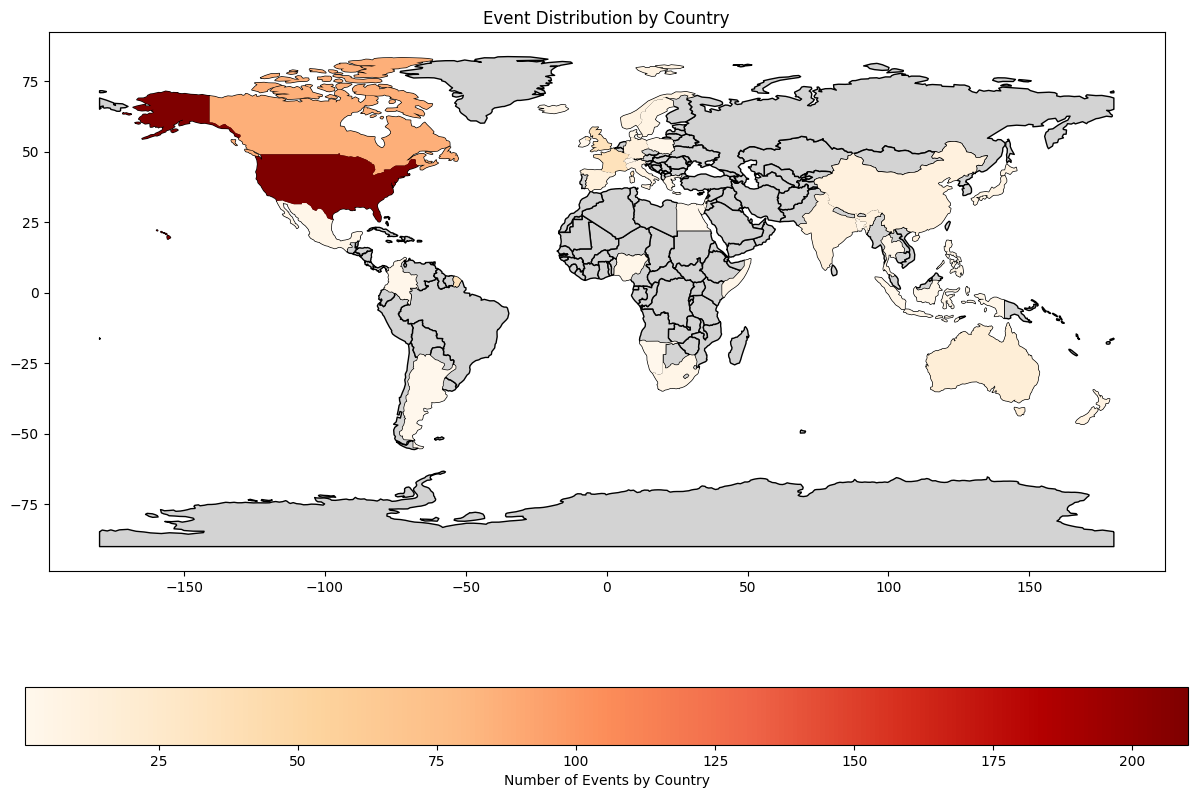

In [37]:
# Plot the distribution of events by country
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black')
merged.plot(column='Number of Events', ax=ax, legend=True,
            cmap='OrRd', legend_kwds={'label': "Number of Events by Country", 'orientation': "horizontal"})
plt.title('Event Distribution by Country')
plt.show()

In [38]:
# Apply logarithmic transformation to 'Number of Events'
merged['Log Number of Events'] = np.log1p(merged['Number of Events'])

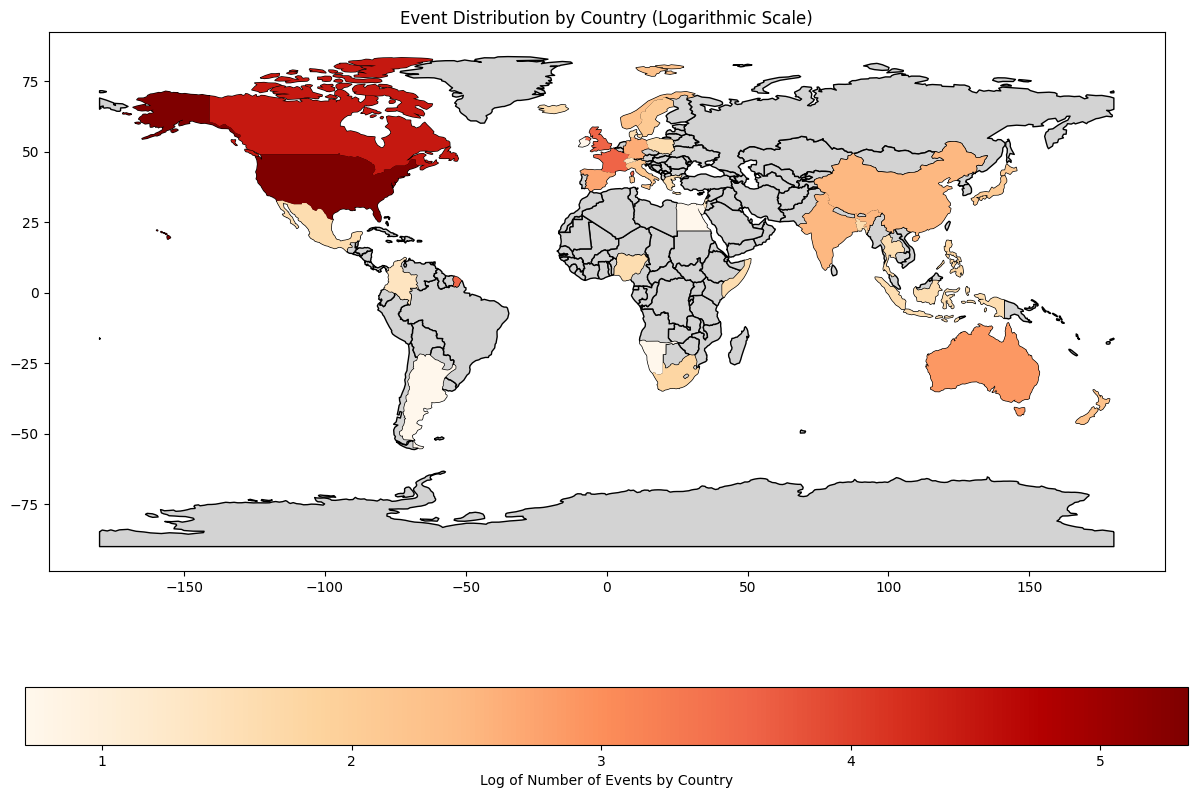

In [39]:
# Plot the data on a logarithmic scale
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black')
merged.plot(column='Log Number of Events', ax=ax, legend=True,
            cmap='OrRd', legend_kwds={'label': "Log of Number of Events by Country", 'orientation': "horizontal"})
plt.title('Event Distribution by Country (Logarithmic Scale)')
plt.show()

In [40]:
# Aggregate data by language groups
language_event_counts = df.groupby('Languages').size().reset_index(name='Number of Events by Language')
df = df.merge(language_event_counts, on='Languages', how='left')
merged_language = world.set_index('Countries').join(df.set_index('Countries'))

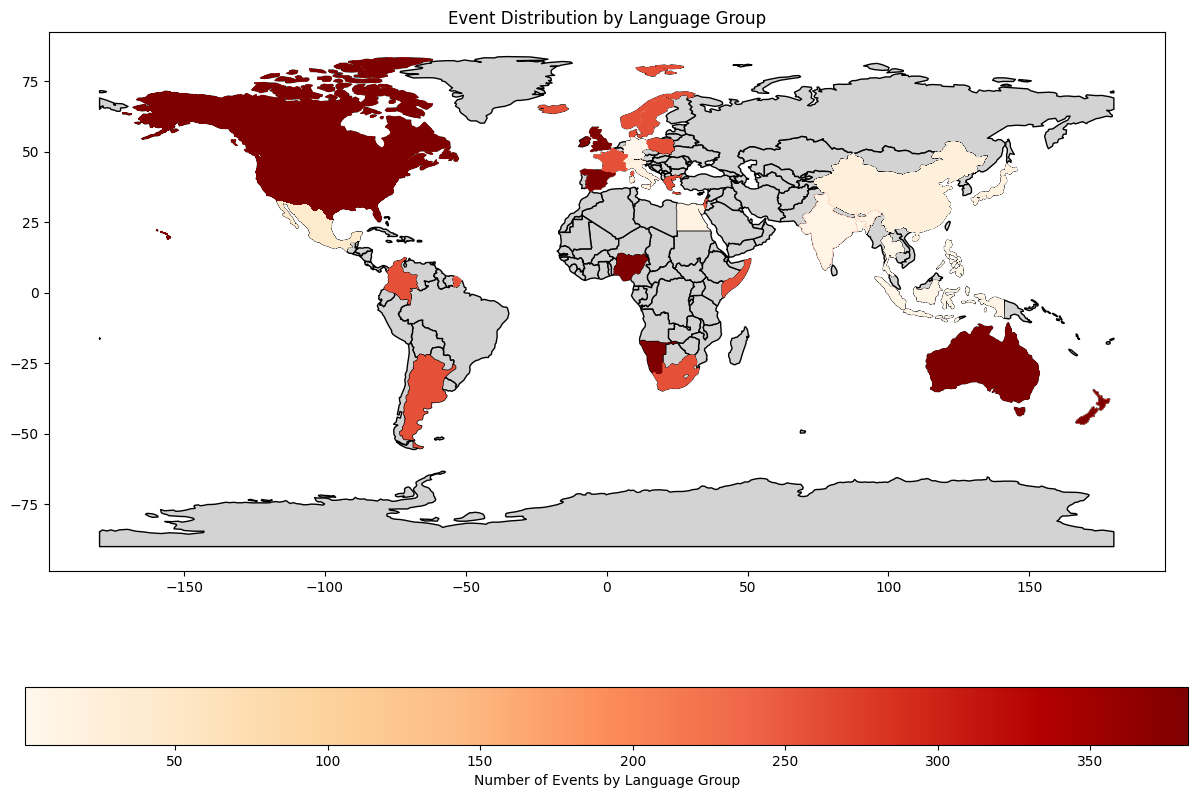

In [41]:
# Plot the data by language groups
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black')
merged_language.plot(column='Number of Events by Language', ax=ax, legend=True,
                     cmap='OrRd', legend_kwds={'label': "Number of Events by Language Group", 'orientation': "horizontal"})
plt.title('Event Distribution by Language Group')
plt.show()

In [42]:
# Apply logarithmic transformation to 'Number of Events by Language'
df['Log Number of Events by Language'] = np.log1p(df['Number of Events by Language'])
merged_language_log = world.set_index('Countries').join(df.set_index('Countries'))

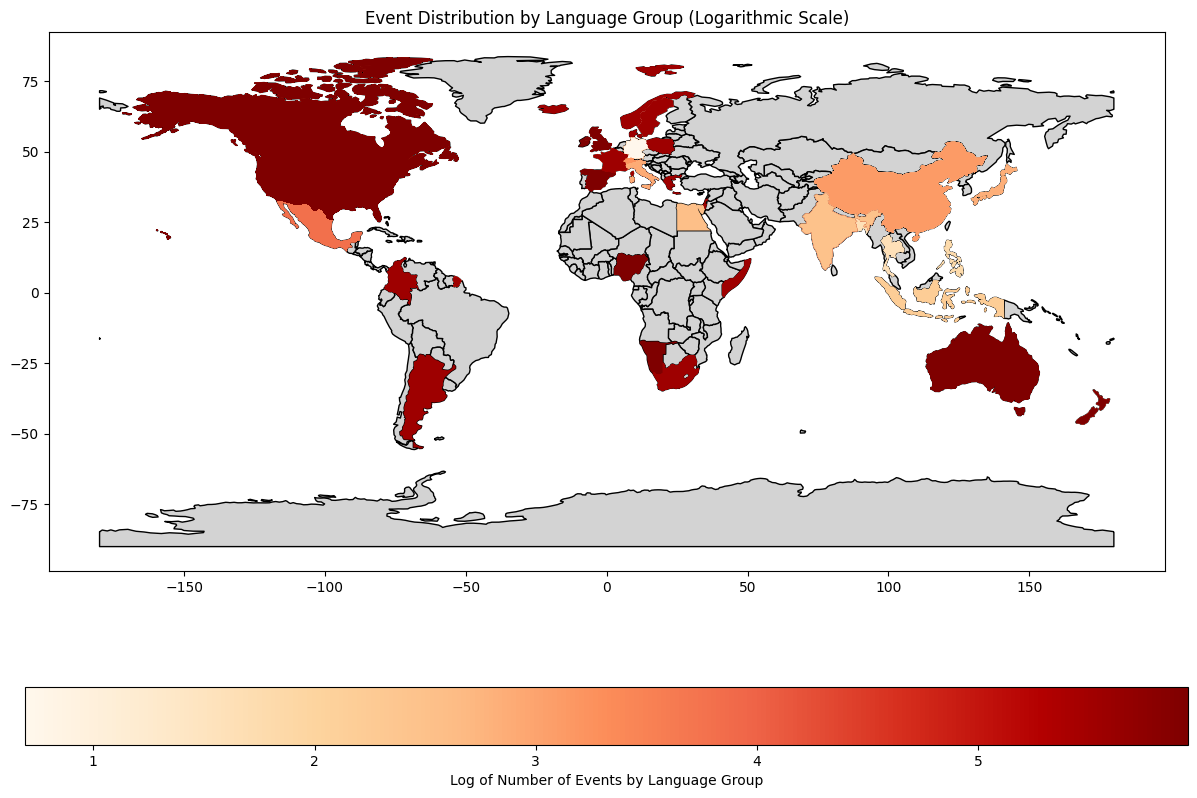

In [43]:
# Plot the data by language groups on a logarithmic scale
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black')
merged_language_log.plot(column='Log Number of Events by Language', ax=ax, legend=True,
                         cmap='OrRd', legend_kwds={'label': "Log of Number of Events by Language Group", 'orientation': "horizontal"})
plt.title('Event Distribution by Language Group (Logarithmic Scale)')
plt.show()


In [44]:
# Define a mapping of languages to their respective language groups
language_group_mapping = {
    'english': 'English',
    'french': 'French',
    'spanish': 'Spanish',
    'portuguese': 'Portuguese',
    'italian': 'Italian',
    'japanese': 'Japanese',
    'korean': 'Korean',
    'german': 'German',
    'greek': 'Greek',
    'dutch': 'Dutch',
    'swedish': 'Scandinavian',
    'norwegian': 'Scandinavian',
    'danish': 'Scandinavian',
    'chinese': 'Chinese',
    'mandarin': 'Chinese',
    'cantonese': 'Chinese',
    'arabic': 'Arabic',
    'hindi': 'Indic',
    'bengali': 'Indic',
    'urdu': 'Indic',
    'russian': 'Slavic',
    'polish': 'Slavic',
    'ukrainian': 'Ukranian',
    'hebrew': 'Hebrew',
    'turkish': 'Turkish',
    'thai': 'Thai',
    'vietnamese': 'Vietnamese',
    'indonesian': 'Indonesian',
    'multilingual': 'Multilingual'
}

# Apply the mapping to create a new 'Language Group' column
df['Language Group'] = df['Languages'].map(lambda x: language_group_mapping.get(x, 'Other'))

In [45]:
# Step 3: Remove empty rows and those categorized as 'Other'
df = df.dropna(subset=['Countries', 'Languages', 'Language Group'])
df = df[df['Language Group'] != 'Other']

In [46]:
# Step 4: Proceed with your aggregation, merging, and plotting
language_group_counts = df.groupby('Language Group').size().reset_index(name='Number of Events by Language Group')
df = df.merge(language_group_counts, on='Language Group', how='left')

In [47]:
# Merge with the world map data using the standardized 'Countries' column
merged_language_group = world.set_index('Countries').join(df.set_index('Countries'))

<ipython-input-48-c3b9bbbd271a>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_groups))


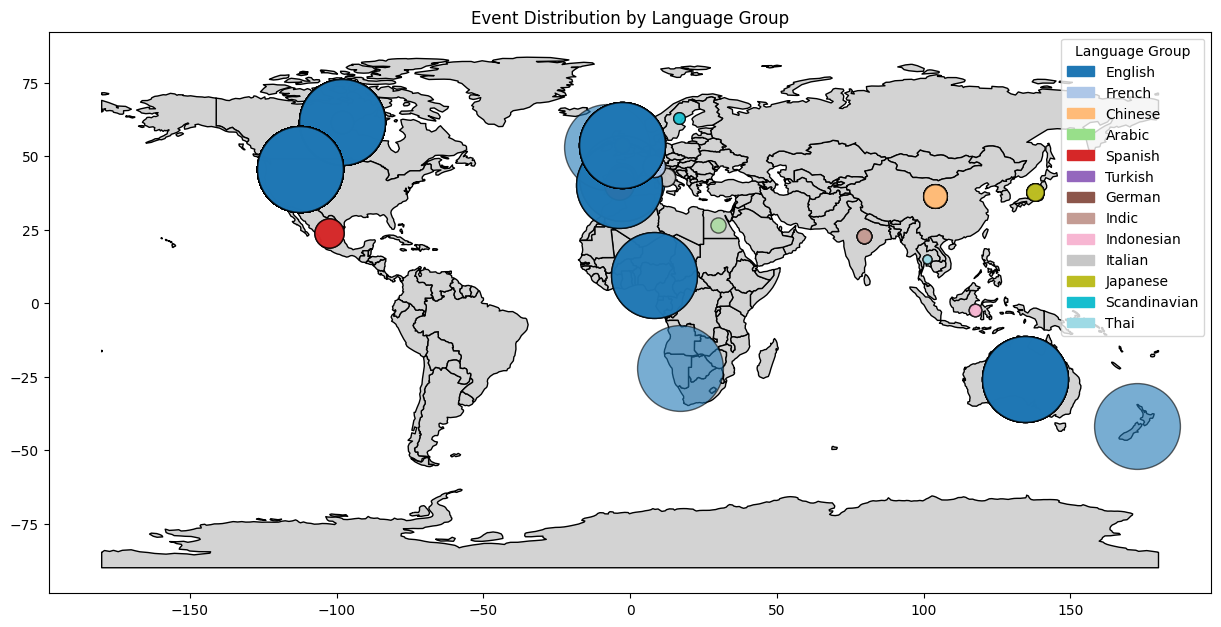

In [48]:
# Plot the data by language groups
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black')

unique_groups = merged_language_group['Language Group'].dropna().unique()
cmap = plt.cm.get_cmap('tab20', len(unique_groups))
color_mapping = dict(zip(unique_groups, cmap.colors))

for idx, row in merged_language_group.dropna(subset=['Number of Events by Language Group']).iterrows():
    ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
               s=row['Number of Events by Language Group'] * 10,
               color=color_mapping[row['Language Group']],
               alpha=0.6, edgecolor='k', zorder=2)

legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in unique_groups]
plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

plt.title('Event Distribution by Language Group')
plt.show()

In [49]:
# Sort the merged_language_group DataFrame by 'Number of Events by Language Group' in descending order
sorted_data = merged_language_group.dropna(subset=['Number of Events by Language Group']).sort_values(by='Number of Events by Language Group', ascending=False)

<ipython-input-50-7a2c92668cc7>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_groups))


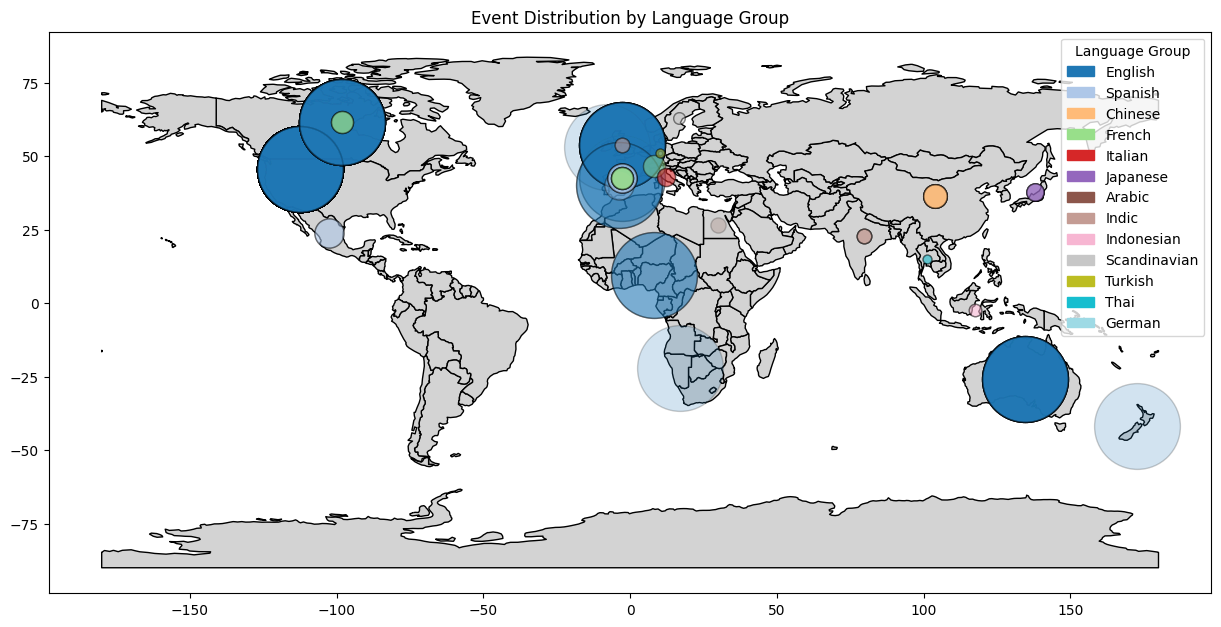

In [50]:
# Plot the data by language groups
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black')

unique_groups = sorted_data['Language Group'].dropna().unique()
cmap = plt.cm.get_cmap('tab20', len(unique_groups))
color_mapping = dict(zip(unique_groups, cmap.colors))

# Iterate over the sorted data to plot circles
for idx, row in sorted_data.iterrows():
    ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
               s=row['Number of Events by Language Group'] * 10,
               color=color_mapping[row['Language Group']],
               alpha=0.2, edgecolor='k', zorder=2)

# Create a legend
legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in unique_groups]
plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

plt.title('Event Distribution by Language Group')
plt.show()

<ipython-input-51-e2b2676fa15e>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_groups))  # Change 'Set1' to any other colormap


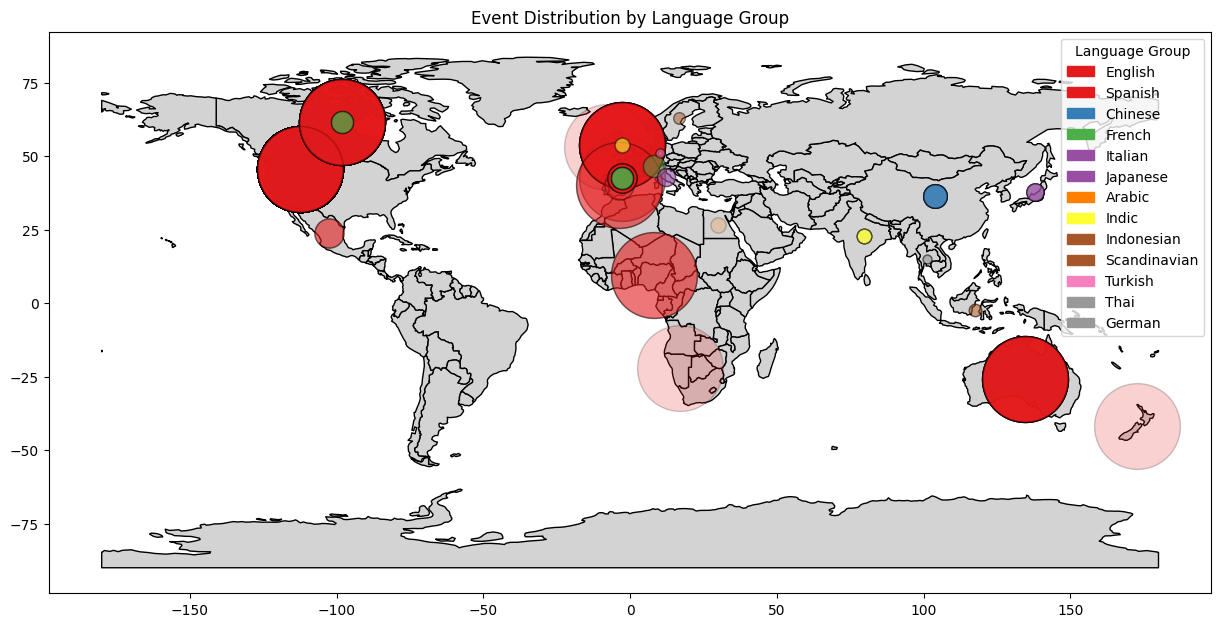

In [51]:
# Plot the data by language groups
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black')

unique_groups = sorted_data['Language Group'].dropna().unique()
cmap = plt.cm.get_cmap('Set1', len(unique_groups))  # Change 'Set1' to any other colormap
color_mapping = dict(zip(unique_groups, cmap.colors))

# Iterate over the sorted data to plot circles
for idx, row in sorted_data.iterrows():
    ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
               s=row['Number of Events by Language Group'] * 10,
               color=color_mapping[row['Language Group']],
               alpha=0.2, edgecolor='k', zorder=2)

# Create a legend
legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in unique_groups]
plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

plt.title('Event Distribution by Language Group')
plt.show()

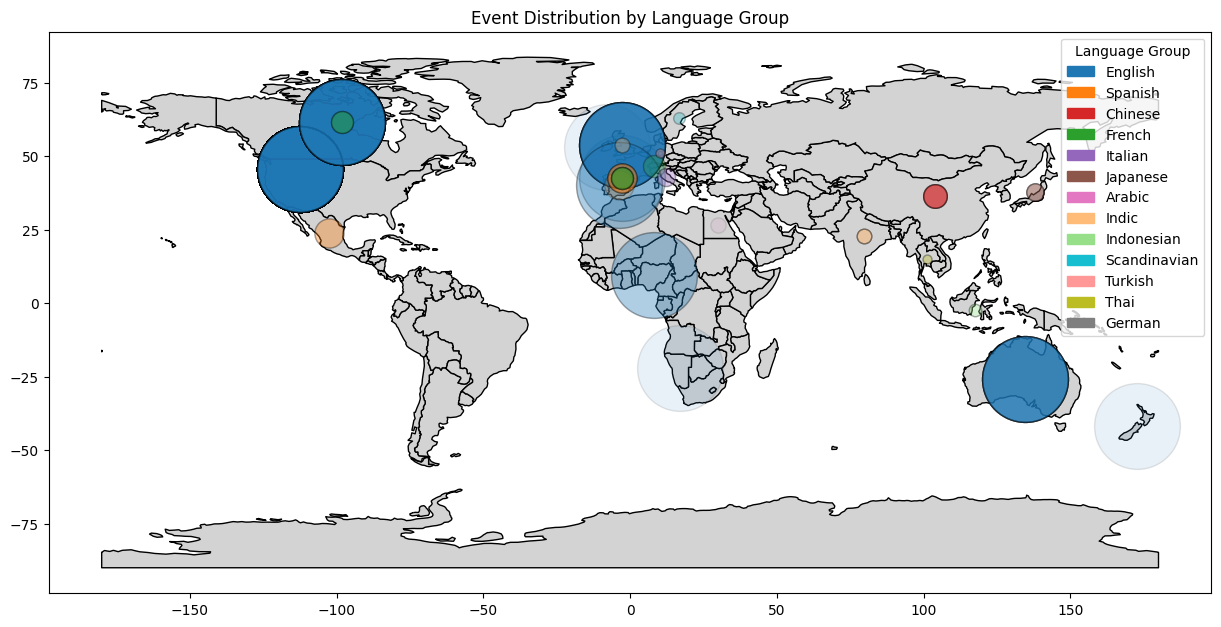

In [52]:
# Define your custom color mapping
custom_colors = {
    'English': '#1f77b4',      # Blue
    'Spanish': '#ff7f0e',      # Orange
    'Chinese': '#d62728',      # Red
    'French': '#2ca02c',       # Green
    'Italian': '#9467bd',      # Purple
    'Japanese': '#8c564b',     # Brown
    'Arabic': '#e377c2',       # Pink
    'Scandinavian': '#17becf', # Teal
    'Thai': '#bcbd22',         # Olive
    'German': '#7f7f7f',       # Grey
    'Indic': '#ffbb78',        # Light Orange
    'Indonesian': '#98df8a',   # Light Green
    'Turkish': '#ff9896',      # Light Red
}
# If a language group is not in the custom_colors, assign a default color
color_mapping = {group: custom_colors.get(group, '#7f7f7f') for group in sorted_data['Language Group'].dropna().unique()}

# Plot the data by language groups
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black')

# Iterate over the sorted data to plot circles
for idx, row in sorted_data.iterrows():
    ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
               s=row['Number of Events by Language Group'] * 10,
               color=color_mapping[row['Language Group']],
               alpha=0.1, edgecolor='k', zorder=2)

# Create a legend
legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in sorted_data['Language Group'].dropna().unique()]
plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

plt.title('Event Distribution by Language Group')
plt.show()

In [53]:
# Calculate the total number of events
total_events = sorted_data['Number of Events by Language Group'].sum()

# Calculate the percentage of each language group
sorted_data['Percentage'] = (sorted_data['Number of Events by Language Group'] / total_events) * 100

# Display the calculated percentages to check the values
print(sorted_data[['Language Group', 'Number of Events by Language Group', 'Percentage']])

              Language Group  Number of Events by Language Group  Percentage
Countries                                                                   
Australia            English                               382.0    0.325145
Australia            English                               382.0    0.325145
United States        English                               382.0    0.325145
United States        English                               382.0    0.325145
United States        English                               382.0    0.325145
...                      ...                                 ...         ...
Thailand                Thai                                 4.0    0.003405
Germany              Turkish                                 4.0    0.003405
Germany              Turkish                                 4.0    0.003405
Germany              Turkish                                 4.0    0.003405
Germany               German                                 1.0    0.000851

In [54]:
# Filter out languages with less than 0.1% of total events
filtered_data = sorted_data[sorted_data['Percentage'] >= 0.01]

# Check the filtered data
print(filtered_data[['Language Group', 'Number of Events by Language Group', 'Percentage']])

              Language Group  Number of Events by Language Group  Percentage
Countries                                                                   
Australia            English                               382.0    0.325145
Australia            English                               382.0    0.325145
United States        English                               382.0    0.325145
United States        English                               382.0    0.325145
United States        English                               382.0    0.325145
...                      ...                                 ...         ...
Japan               Japanese                                16.0    0.013619
Japan               Japanese                                16.0    0.013619
Japan               Japanese                                16.0    0.013619
Japan               Japanese                                16.0    0.013619
Egypt                 Arabic                                12.0    0.010214

<ipython-input-55-e7f9aa100a1f>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_groups))


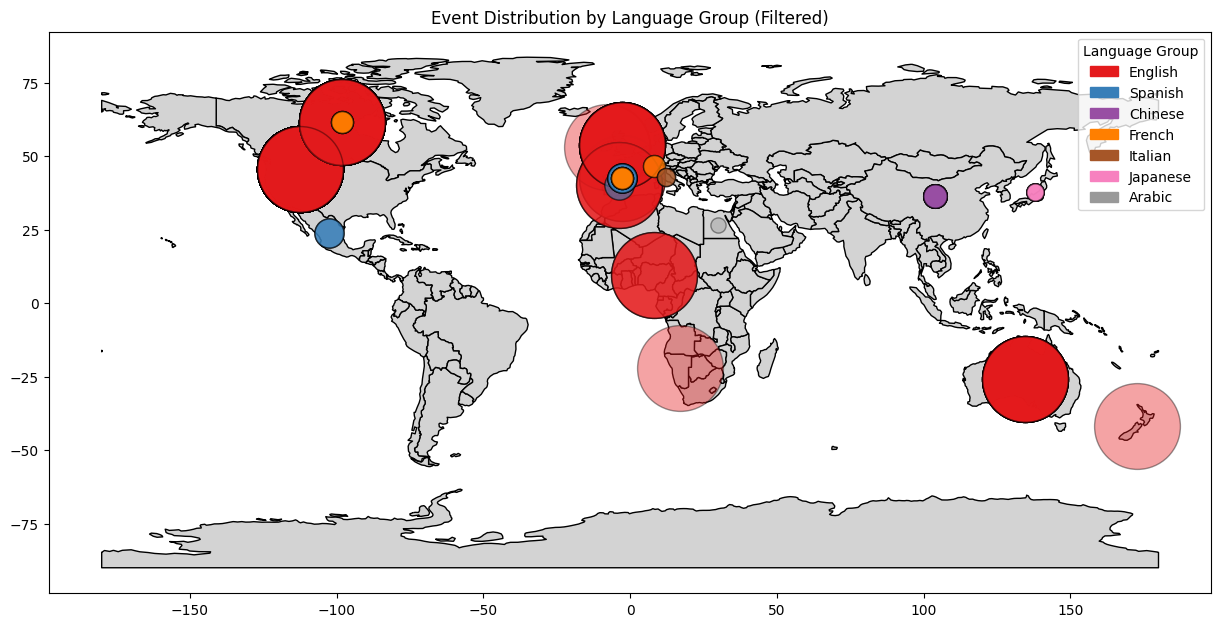

In [55]:
# Plot the filtered data by language groups
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black')

unique_groups = filtered_data['Language Group'].dropna().unique()
cmap = plt.cm.get_cmap('Set1', len(unique_groups))
color_mapping = dict(zip(unique_groups, cmap.colors))

# Iterate over the filtered data to plot circles
for idx, row in filtered_data.iterrows():
    ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
               s=row['Number of Events by Language Group'] * 10,
               color=color_mapping[row['Language Group']],
               alpha=0.4, edgecolor='k', zorder=2)

# Create a legend
legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in unique_groups]
plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

plt.title('Event Distribution by Language Group (Filtered)')
plt.show()

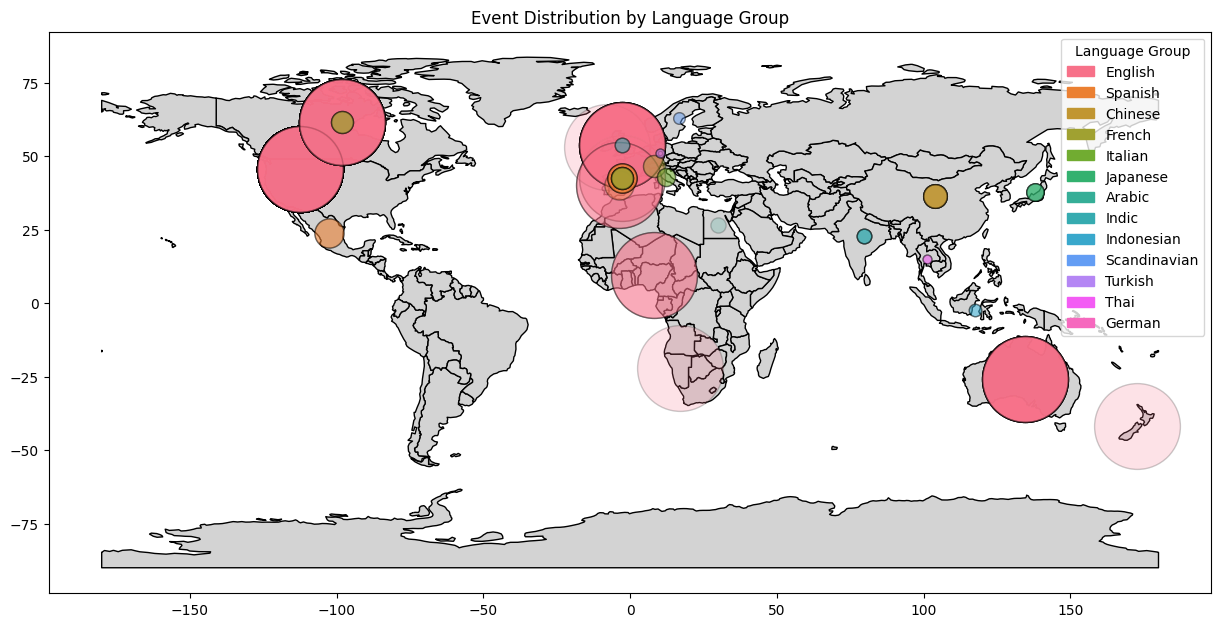

In [58]:
# Seaborn color palette
unique_groups = sorted_data['Language Group'].dropna().unique()  # Ensure all groups are captured
palette = sns.color_palette("husl", len(unique_groups))  # Generate enough colors for all groups
color_mapping = dict(zip(unique_groups, palette))  # Map colors to each group

# Plot the data by language groups
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black')

# Iterate over the sorted data to plot circles
for idx, row in sorted_data.iterrows():
    # Safely access the color mapping with a default color if a group is missing
    color = color_mapping.get(row['Language Group'], '#7f7f7f')  # Default to grey if group not found
    ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
               s=row['Number of Events by Language Group'] * 10,
               color=color,
               alpha=0.2, edgecolor='k', zorder=2)

# Create a legend
legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in unique_groups]
plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

plt.title('Event Distribution by Language Group')
plt.show()

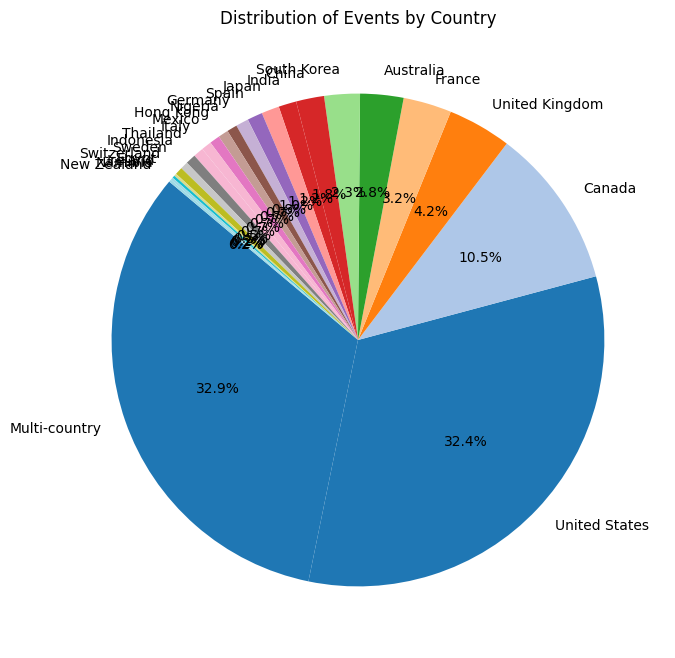

In [57]:
# Pie chart for distribution by countries
country_distribution = df['Countries'].value_counts()
plt.figure(figsize=(10, 8))
country_distribution.plot.pie(autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title('Distribution of Events by Country')
plt.ylabel('')
plt.show()